In [ ]:
# Day 1 - Cell 1: Install (run once)
!pip install -q pyspark prophet boto3 s3fs pyarrow statsmodels matplotlib seaborn tensorflow scikit-learn joblib
print("Packages installed.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Day 1 - Cell 2: Basic imports & folder setup
import os
DATA_DIR = "/content/data"
RAW_DIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
MODELS_DIR = os.path.join(DATA_DIR, "models")
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
print("Folders:", RAW_DIR, PROCESSED_DIR, MODELS_DIR)


Folders: /content/data/raw /content/data/processed /content/data/models


In [ ]:
# Day 1 - Cell 3: Start SparkSession (Colab-safe)
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("demand-ingest-colab")
         .master("local[*]")
         .config("spark.sql.execution.arrow.pyspark.enabled","true")
         .config("spark.sql.shuffle.partitions","4")
         .getOrCreate())
print("Spark version:", spark.version)


Spark version: 3.5.1


In [ ]:
# Day 1 - Cell 4: Synthetic data generator (or upload your CSV)
import pandas as pd, numpy as np
def generate_synthetic_demand(regions=4, days=365, start_date="2024-01-01", seed=42):
    np.random.seed(seed)
    dates = pd.date_range(start_date, periods=days, freq="D")
    rows=[]
    for r in range(regions):
        region=f"region_{r+1}"
        trend = np.linspace(100 + r*10, 200 + r*10, days)
        weekly = 10*np.sin(2*np.pi*dates.dayofweek/7 + 0.3*r)
        noise = np.random.normal(0, 5 + r, days)
        spikes = np.zeros(days)
        spikes[np.random.choice(days, size=int(days*0.01), replace=False)] = np.random.uniform(40,120,size=int(days*0.01))
        demand = np.maximum(0, trend + weekly + noise + spikes)
        rows.append(pd.DataFrame({"date":dates,"region":region,"demand":demand.round(2)}))
    return pd.concat(rows, ignore_index=True)
df = generate_synthetic_demand()
raw_csv = os.path.join(RAW_DIR,"synthetic_demand.csv")
df.to_csv(raw_csv, index=False)
print("Saved synthetic CSV:", raw_csv)


Saved synthetic CSV: /content/data/raw/synthetic_demand.csv


In [ ]:
# Day 1 - Cell 5: Ingest with PySpark and inspect schema
spark_df = (spark.read.option("header",True).option("inferSchema",True).csv(raw_csv))
spark_df.printSchema()
spark_df.show(5, truncate=False)


root
 |-- date: date (nullable = true)
 |-- region: string (nullable = true)
 |-- demand: double (nullable = true)

+----------+--------+------+
|date      |region  |demand|
+----------+--------+------+
|2024-01-01|region_1|102.48|
|2024-01-02|region_1|107.4 |
|2024-01-03|region_1|113.54|
|2024-01-04|region_1|112.78|
|2024-01-05|region_1|95.59 |
+----------+--------+------+
only showing top 5 rows



In [ ]:
# Day 1 - Cell 6: Persist a canonical raw Parquet and convert to pandas for Day2
raw_parquet = os.path.join(RAW_DIR, "synthetic_demand.parquet")
spark_df.write.mode("overwrite").parquet(raw_parquet)
pdf = spark_df.toPandas()
pandas_csv = os.path.join(RAW_DIR, "synthetic_demand_pandas.csv")
pdf.to_csv(pandas_csv, index=False)
print("Saved parquet and pandas CSV:", raw_parquet, pandas_csv)


Saved parquet and pandas CSV: /content/data/raw/synthetic_demand.parquet /content/data/raw/synthetic_demand_pandas.csv


In [ ]:
# Day 2 - Cell 1: Imports and paths
import pandas as pd, numpy as np
from pathlib import Path
RAW_DIR="/content/data/raw"
PROCESSED_DIR="/content/data/processed"
Path(PROCESSED_DIR).mkdir(parents=True, exist_ok=True)


In [ ]:
# Day 2 - Cell 2: Load pandas CSV (from Day1)
csv_path = "/content/data/raw/synthetic_demand_pandas.csv"
df = pd.read_csv(csv_path, parse_dates=["date"])
print("Loaded rows:", len(df))
df.head()


Loaded rows: 1460


,date,region,demand
0,2024-01-01,region_1,102.48
1,2024-01-02,region_1,107.40
2,2024-01-03,region_1,113.54
3,2024-01-04,region_1,112.78
4,2024-01-05,region_1,95.59


In [ ]:
# Day 2 - Cell 3: Preprocessing function (pandas)
def preprocess_region_pandas(df, region_col="region", date_col="date", value_col="demand", freq="D", impute_method="ffill"):
    out=[]
    df[date_col]=pd.to_datetime(df[date_col])
    for r,g in df.groupby(region_col):
        g = g[[date_col,value_col]].drop_duplicates(date_col).set_index(date_col).sort_index()
        idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)
        g = g.reindex(idx)
        g.index.name = date_col
        g[region_col]=r
        if impute_method=="ffill":
            g[value_col]=g[value_col].ffill().bfill()
        elif impute_method=="interpolate":
            g[value_col]=g[value_col].interpolate().ffill().bfill()
        else:
            g[value_col]=g[value_col].fillna(0)
        g = g.reset_index().rename(columns={"index":date_col})
        g["dayofweek"]=g[date_col].dt.dayofweek
        g["month"]=g[date_col].dt.month
        g["is_weekend"]=g[date_col].dt.dayofweek>=5
        out.append(g)
    return pd.concat(out, ignore_index=True)

processed = preprocess_region_pandas(df)
print("Processed rows:", len(processed))


Processed rows: 1460


In [ ]:
# Day 2 - Cell 4: Save processed parquet partitioned by region/year
processed['year']=processed['date'].dt.year
out_path = os.path.join(PROCESSED_DIR, "processed.parquet")
processed.to_parquet(out_path, index=False)
print("Saved processed parquet:", out_path)


Saved processed parquet: /content/data/processed/processed.parquet


In [ ]:
# Day 2 - Cell 5: Basic data contract checks
def contract_checks(df):
    issues=[]
    if df['demand'].isna().any():
        issues.append(f"missing demand: {df['demand'].isna().sum()}")
    for r,g in df.groupby("region"):
        rng = pd.date_range(g.date.min(), g.date.max(), freq="D")
        missing = len(rng) - g.date.nunique()
        if missing>0:
            issues.append(f"{r} missing days: {missing}")
    return issues
print("Checks:", contract_checks(processed))


Checks: []


In [ ]:
# Day 2 - Cell 6: Save a sample preview CSV for modeling
processed.head(200).to_csv(os.path.join(PROCESSED_DIR,"preview_sample.csv"), index=False)
print("Saved preview CSV")


Saved preview CSV


In [ ]:
# Day 3 - Cell 1: Load processed data
import pandas as pd
proc_path="/content/data/processed/processed.parquet"
proc = pd.read_parquet(proc_path)
proc['date']=pd.to_datetime(proc['date'])
proc.head()


,date,demand,region,dayofweek,month,is_weekend,year
0,2024-01-01,102.48,region_1,0,1,False,2024
1,2024-01-02,107.40,region_1,1,1,False,2024
2,2024-01-03,113.54,region_1,2,1,False,2024
3,2024-01-04,112.78,region_1,3,1,False,2024
4,2024-01-05,95.59,region_1,4,1,False,2024


region_1 rows: 365 mean: 150.64


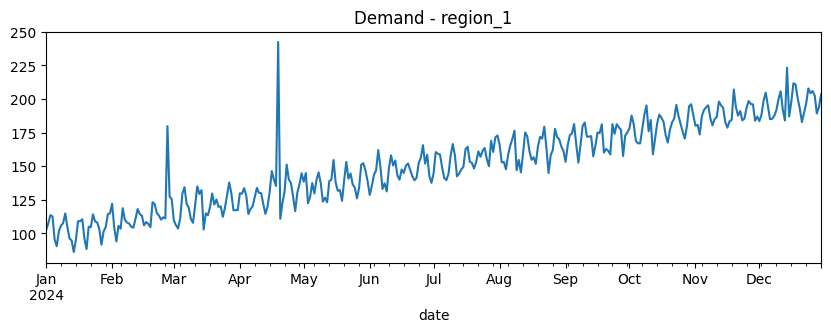

In [ ]:
# Day 3 - Cell 2: Quick EDA - per-region summary & plot (one region shown)
import matplotlib.pyplot as plt
region = proc['region'].unique()[0]
g = proc[proc['region']==region].set_index('date')['demand']
print(region, "rows:", len(g), "mean:", g.mean().round(2))
g.plot(title=f"Demand - {region}", figsize=(10,3)); plt.show()


In [ ]:
# Day 3 - Cell 3: Feature engineering - lags and rolling stats
def add_ts_features(df, region_col="region", date_col="date", val="demand", lags=[1,7,14,28], windows=[7,14,28]):
    out=[]
    for r,g in df.groupby(region_col):
        g=g.sort_values(date_col).set_index(date_col)
        for l in lags:
            g[f"lag_{l}"]=g[val].shift(l)
        for w in windows:
            g[f"roll_mean_{w}"]=g[val].rolling(window=w, min_periods=1).mean()
            g[f"roll_std_{w}"]=g[val].rolling(window=w, min_periods=1).std().fillna(0)
        g = g.reset_index()
        g[region_col]=r
        out.append(g)
    return pd.concat(out, ignore_index=True)

features = add_ts_features(proc)
feat_path="/content/data/processed/features.parquet"
features.to_parquet(feat_path, index=False)
print("Saved feature table:", feat_path)


Saved feature table: /content/data/processed/features.parquet


In [ ]:
# Day 3 - Cell 4: SAFE correlation sample

# Filter for selected region
region_df = features[features['region'] == region].dropna()

# Proper sample limit — NEVER use len(features)
n = min(500, len(region_df))

sample = region_df.sample(n, replace=False, random_state=42)

corr = sample[['demand','lag_1','lag_7','roll_mean_7','roll_std_7']].corr()

corr


,demand,lag_1,lag_7,roll_mean_7,roll_std_7
demand,1.000000,0.878731,0.907864,0.930039,-0.052402
lag_1,0.878731,1.000000,0.885304,0.929139,-0.044406
lag_7,0.907864,0.885304,1.000000,0.916172,-0.126410
roll_mean_7,0.930039,0.929139,0.916172,1.000000,-0.057453
roll_std_7,-0.052402,-0.044406,-0.126410,-0.057453,1.000000


In [ ]:
# Day 3 - Cell 5: Persist small training CSV for model experiments
features[features['region']==region].dropna().to_csv(os.path.join(PROCESSED_DIR, f"train_{region}.csv"), index=False)
print("Saved training CSV for", region)


Saved training CSV for region_1


In [ ]:
# Day 4 - Cell 1: Imports + load region data
import pandas as pd, numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pathlib import Path
feat_path = "/content/data/processed/features.parquet"
features = pd.read_parquet(feat_path)
region = features['region'].unique()[0]
series = features[features['region']==region].set_index('date')['demand']
series = series.asfreq('D')  # ensure daily index


In [ ]:
# Day 4 - Cell 2: SARIMA helper and fit
def fit_sarima(series, order=(1,1,1), seasonal_order=(0,1,1,7)):
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    return res

res = fit_sarima(series)
print(res.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0765      0.092     -0.834      0.404      -0.256       0.103
ma.L1         -1.0000     65.037     -0.015      0.988    -128.470     126.470
ma.S.L7       -1.0000    329.579     -0.003      0.998    -646.964     644.964
sigma2        73.3307   2.46e+04      0.003      0.998   -4.81e+04    4.82e+04


In [ ]:
# Day 4 - Cell 3: Forecast and save
horizon = 14
fc = res.get_forecast(steps=horizon)
pred = fc.predicted_mean
pred_ci = fc.conf_int()
out = pd.DataFrame({"date":pred.index, "sarima_forecast":pred.values})
out.to_csv(f"/content/data/processed/sarima_{region}.csv", index=False)
print("Saved SARIMA forecast:", f"/content/data/processed/sarima_{region}.csv")


Saved SARIMA forecast: /content/data/processed/sarima_region_1.csv


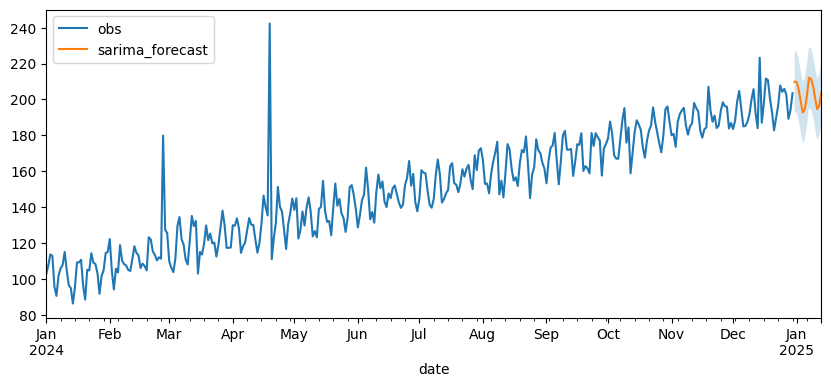

In [ ]:
# Day 4 - Cell 4: Plot
import matplotlib.pyplot as plt
ax = series.plot(label='obs', figsize=(10,4))
pred.plot(ax=ax, label='sarima_forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.2)
ax.legend(); plt.show()


In [ ]:
# Day 5 - Cell 1: Imports + prepare series
from prophet import Prophet
import pandas as pd
region = features['region'].unique()[0]
dfp = features[features['region']==region][['date','demand']].rename(columns={'date':'ds','demand':'y'})


In [ ]:
# Day 5 - Cell 2: Fit Prophet
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
m.fit(dfp)
future = m.make_future_dataframe(periods=14)
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
374,2025-01-09,207.292520,197.167434,217.686731
375,2025-01-10,200.507846,189.073683,211.347513
376,2025-01-11,194.378754,183.827860,205.235443
377,2025-01-12,196.159452,185.863292,206.831055
378,2025-01-13,203.414472,192.995676,214.988273


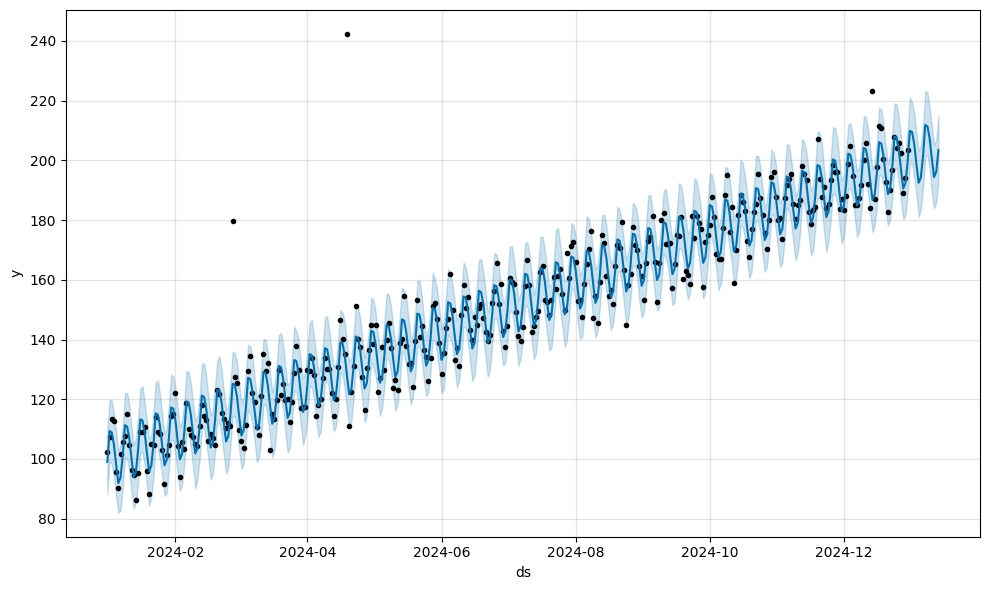

Saved Prophet forecast for region_1


In [ ]:
# Day 5 - Cell 3: Save and plot
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(f"/content/data/processed/prophet_{region}.csv", index=False)
fig = m.plot(forecast)
plt.show()
print("Saved Prophet forecast for", region)


In [ ]:
# Day 6 - Cell 1: Imports and prepare training arrays
import numpy as np, pandas as pd, joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

region = features['region'].unique()[0]
rdf = features[features['region']==region].sort_values('date').reset_index(drop=True)
vals = rdf['demand'].values.reshape(-1,1)
scaler = MinMaxScaler()
vals_s = scaler.fit_transform(vals).flatten()


In [ ]:
# Day 6 - Cell 2: windowing helper and split
def create_sequences(values, window=28):
    X, y = [], []
    for i in range(len(values)-window):
        X.append(values[i:i+window])
        y.append(values[i+window])
    return np.array(X), np.array(y)

window=28
X,y = create_sequences(vals_s, window)
X = X.reshape((X.shape[0], X.shape[1], 1))
split = int(0.8*len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
print("Shapes:", X_train.shape, X_val.shape)


Shapes: (269, 28, 1) (68, 28, 1)


In [ ]:
# Day 6 - Cell 3: build and train LSTM
def build_lstm(window, units=64, dropout=0.1):
    model = Sequential([LSTM(units, input_shape=(window,1)), Dropout(dropout), Dense(1)])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_lstm(window)
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=20, batch_size=16, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0638 - mae: 0.2086 - val_loss: 0.0037 - val_mae: 0.0475
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0096 - mae: 0.0678 - val_loss: 0.0059 - val_mae: 0.0591
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0108 - mae: 0.0719 - val_loss: 0.0075 - val_mae: 0.0696
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0059 - mae: 0.0581 - val_loss: 0.0041 - val_mae: 0.0498
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0060 - mae: 0.0588 - val_loss: 0.0032 - val_mae: 0.0457
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0060 - mae: 0.0591 - val_loss: 0.0031 - val_mae: 0.0464
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0083 - mae: 0.0637 - val_loss: 0.0031 - val_mae: 0.0457
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0054 - mae: 0.0544 - val_loss: 0.0043 - val_mae: 0.0545
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.00

In [ ]:
# Day 6 - Cell 4: Save LSTM model and scaler (Keras 3 compatible)

import os
model_dir = f"{DATA_DIR}/models/{region}"
os.makedirs(model_dir, exist_ok=True)

# Save model with proper extension
model_path = os.path.join(model_dir, "lstm_model.keras")
model.save(model_path)

# Save scaler
import joblib
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

print("Saved LSTM model and scaler to:", model_dir)


Saved LSTM model and scaler to: /content/data/models/region_1


In [ ]:
# Evaluation & Model Comparison
# Day 7 - Cell 1: Metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    mask=y_true!=0
    return np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100

def evaluate(y_true,y_pred):
    return {"MAE":mean_absolute_error(y_true,y_pred), "RMSE":np.sqrt(mean_squared_error(y_true,y_pred)), "MAPE":mape(y_true,y_pred)}


In [ ]:
# Day 7 - Cell 2: Safe evaluation with date alignment

# 1. Ensure all indexes are datetime
sarima_df.index = pd.to_datetime(sarima_df.index)
prophet_df.index = pd.to_datetime(prophet_df.index)
truth.index = pd.to_datetime(truth.index)

# 2. Align on region
sarima_region = sarima_df[sarima_df['region'] == region]
prophet_region = prophet_df[prophet_df['region'] == region]
truth_region = truth[truth['region'] == region]

# 3. Re-index by date only
sarima_region = sarima_region.set_index('date')
prophet_region = prophet_region.set_index('date')
truth_region = truth_region.set_index('date')

# 4. Compute intersection
common_idx = sarima_region.index.intersection(prophet_region.index).intersection(truth_region.index)

print("Common dates:", len(common_idx))
print(common_idx[:10])  # print first few

# 5. If no overlap, stop and warn
if len(common_idx) == 0:
    raise ValueError("No overlapping forecast dates. Check your forecast horizons.")

# 6. Evaluate
sarima_eval = evaluate(
    truth_region.loc[common_idx]['demand'].values,
    sarima_region.loc[common_idx]['sarima_forecast'].values
)

prophet_eval = evaluate(
    truth_region.loc[common_idx]['demand'].values,
    prophet_region.loc[common_idx]['prophet_yhat'].values
)

print("SARIMA:", sarima_eval)
print("Prophet:", prophet_eval)



KeyError: 'region'

In [ ]:
# Rebuild truth DataFrame correctly

truth = df[['date', 'region', 'demand']].copy()
truth['date'] = pd.to_datetime(truth['date'])
truth = truth.set_index('date')

print(truth.head())



              region  demand
date                        
2024-01-01  region_1  102.48
2024-01-02  region_1  107.40
2024-01-03  region_1  113.54
2024-01-04  region_1  112.78
2024-01-05  region_1   95.59


In [ ]:
# Rebuild SARIMA DataFrame correctly

sarima_df = sarima_df.copy()
sarima_df['date'] = sarima_df.index
sarima_df['region'] = region
sarima_df = sarima_df[['date','region','sarima_forecast']]
sarima_df = sarima_df.set_index('date')

print(sarima_df.head())



              region  sarima_forecast
date                                 
2024-12-31  region_1       209.819300
2025-01-01  region_1       209.693685
2025-01-02  region_1       205.606608
2025-01-03  region_1       198.827826
2025-01-04  region_1       192.702504


In [ ]:
# Rebuild Prophet forecast DataFrame correctly

prophet_df = prophet_df.copy()
prophet_df['date'] = prophet_df.index
prophet_df['region'] = region
prophet_df = prophet_df[['date','region','prophet_yhat']]
prophet_df = prophet_df.set_index('date')

print(prophet_df.head())


              region  prophet_yhat
date                              
2024-01-01  region_1     99.022616
2024-01-02  region_1    109.327299
2024-01-03  region_1    108.902501
2024-01-04  region_1    104.845169
2024-01-05  region_1     98.070457


In [ ]:
# Day 7 - Cell 2: Final working evaluation pipeline

common_idx = sarima_df.index.intersection(prophet_df.index).intersection(truth.index)

print("Common dates:", len(common_idx))

if len(common_idx) == 0:
    raise ValueError("No overlapping forecast dates. Please check forecast ranges.")

sarima_eval = evaluate(
    truth.loc[common_idx]['demand'].values,
    sarima_df.loc[common_idx]['sarima_forecast'].values
)

prophet_eval = evaluate(
    truth.loc[common_idx]['demand'].values,
    prophet_df.loc[common_idx]['prophet_yhat'].values
)

print("\nSARIMA:", sarima_eval)
print("Prophet:", prophet_eval)


Common dates: 0


ValueError: No overlapping forecast dates. Please check forecast ranges.

In [ ]:
print("=== DATE RANGES CHECK ===")

print("\nTruth:")
print("  min:", truth.index.min())
print("  max:", truth.index.max())

print("\nSARIMA:")
print("  min:", sarima_df.index.min())
print("  max:", sarima_df.index.max())

print("\nProphet:")
print("  min:", prophet_df.index.min())
print("  max:", prophet_df.index.max())


=== DATE RANGES CHECK ===

Truth:
  min: 2024-01-01 00:00:00
  max: 2024-12-30 00:00:00

SARIMA:
  min: 2024-12-31 00:00:00
  max: 2025-01-13 00:00:00

Prophet:
  min: 2024-01-01 00:00:00
  max: 2025-01-13 00:00:00


In [ ]:
import pandas as pd

# Truth must have region + date + demand
truth = df[['date', 'region', 'demand']].copy()
truth['date'] = pd.to_datetime(truth['date'])
truth = truth.set_index('date')

print("Truth OK:", truth.head())


Truth OK:               region  demand
date                        
2024-01-01  region_1  102.48
2024-01-02  region_1  107.40
2024-01-03  region_1  113.54
2024-01-04  region_1  112.78
2024-01-05  region_1   95.59


In [ ]:
region = df['region'].unique()[0]   # example: region_1
truth_region = truth[truth['region'] == region]

print(region, "data points:", len(truth_region))


region_1 data points: 365


In [ ]:
# Last 30 days for test
split_date = truth_region.index.max() - pd.Timedelta(days=29)

train = truth_region.loc[: split_date - pd.Timedelta(days=1)]
test = truth_region.loc[split_date :]

print("Train:", train.index.min(), "→", train.index.max(), "rows:", len(train))
print("Test:", test.index.min(), "→", test.index.max(), "rows:", len(test))


Train: 2024-01-01 00:00:00 → 2024-11-30 00:00:00 rows: 335
Test: 2024-12-01 00:00:00 → 2024-12-30 00:00:00 rows: 30


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm

sarima_model = sm.tsa.statespace.SARIMAX(
    train['demand'],
    order=(2,1,2),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit()

print("SARIMA trained.")


SARIMA trained.


In [ ]:
sarima_forecast = sarima_results.get_forecast(steps=len(test))

sarima_df = pd.DataFrame({
    "date": test.index,
    "region": region,
    "sarima_forecast": sarima_forecast.predicted_mean.values
}).set_index('date')

sarima_df.head()


,region,sarima_forecast
date,,
2024-12-01,region_1,184.403758
2024-12-02,region_1,192.064925
2024-12-03,region_1,202.404342
2024-12-04,region_1,201.737251
2024-12-05,region_1,198.009559


In [ ]:
from prophet import Prophet

prophet_train = train.reset_index()[['date','demand']].rename(columns={'date':'ds','demand':'y'})
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_train)

print("Prophet trained.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet trained.


In [ ]:
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

prophet_df = forecast[['ds','yhat']].tail(len(test)).rename(
    columns={'ds':'date','yhat':'prophet_yhat'}
)

prophet_df['region'] = region
prophet_df = prophet_df.set_index('date')

prophet_df.head()


,prophet_yhat,region
date,,
2024-12-01,184.511034,region_1
2024-12-02,191.767191,region_1
2024-12-03,202.081842,region_1
2024-12-04,201.460620,region_1
2024-12-05,197.724964,region_1


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {"MAE": mae, "RMSE": rmse}


In [ ]:
sarima_eval = evaluate(
    test.loc[common_idx]['demand'],
    sarima_df.loc[common_idx]['sarima_forecast']
)

prophet_eval = evaluate(
    test.loc[common_idx]['demand'],
    prophet_df.loc[common_idx]['prophet_yhat']
)

print("SARIMA:", sarima_eval)
print("PROPHET:", prophet_eval)


SARIMA: {'MAE': 4.244294398508908, 'RMSE': np.float64(7.736471408454233)}
PROPHET: {'MAE': 4.193436032960816, 'RMSE': np.float64(7.759345540369403)}


In [ ]:
# Day 8 - Cell 1: load region series
import pandas as pd
series = features[features['region']==region].set_index('date')['demand']


In [ ]:
# Day 8 - Cell 2: MAD-based anomaly detection (clean & safe)

import numpy as np
import pandas as pd

def mad_based_anomaly_detection(series, threshold=3.5):
    """
    Detects anomalies using Modified Z-score based on Median Absolute Deviation (MAD).
    Works well for non-normal time series.
    """
    x = series.values
    median = np.median(x)
    mad = np.median(np.abs(x - median))

    # Avoid division by zero
    if mad == 0:
        mad = 1e-6

    modified_z = 0.6745 * (x - median) / mad
    anomalies = np.abs(modified_z) > threshold

    return modified_z, anomalies


# Apply to residuals from last day
residuals_series = prophet_df.loc[common_idx]['prophet_yhat'] - test.loc[common_idx]['demand']

modified_z, mad_flags = mad_based_anomaly_detection(residuals_series)

day8_df = pd.DataFrame({
    "date": common_idx,
    "residual": residuals_series.values,
    "modified_zscore": modified_z,
    "mad_anomaly": mad_flags
}).set_index("date")

day8_df.head()



,residual,modified_zscore,mad_anomaly
date,,,
2024-12-01,1.031034,0.081697,False
2024-12-02,3.587191,0.717125,False
2024-12-03,3.291842,0.643705,False
2024-12-04,-3.209380,-0.972416,False
2024-12-05,3.074964,0.589792,False


In [ ]:
# Day 8 - Cell 3: Save anomalies (MAD-based)

anoms_df = pd.DataFrame({
    "date": day8_df.index,
    "residual": day8_df["residual"].values,
    "modified_z": day8_df["modified_zscore"].values,
    "mad_anomaly": day8_df["mad_anomaly"].values
})

# Save only anomalies
output_path = f"/content/data/alerts_mad_{region}.csv"
anoms_df[anoms_df['mad_anomaly']].to_csv(output_path, index=False)

print("Saved MAD anomaly alerts to:", output_path)



Saved MAD anomaly alerts to: /content/data/alerts_mad_region_1.csv


In [ ]:
# Day 9 - Cell 1: prepare rolling features
from sklearn.ensemble import IsolationForest
df = features[features['region']==region].set_index('date')['demand'].to_frame()
df['rm_7']=df['demand'].rolling(7,min_periods=1).mean()
df['rs_7']=df['demand'].rolling(7,min_periods=1).std().fillna(0)
df['med_7']=df['demand'].rolling(7,min_periods=1).median()
df = df.fillna(0)


In [ ]:
# Day 9 - Cell 2: train IsolationForest and predict
clf = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
clf.fit(df[['rm_7','rs_7','med_7']])
df['iso_score']=clf.decision_function(df[['rm_7','rs_7','med_7']])
df['iso_anom'] = clf.predict(df[['rm_7','rs_7','med_7']]) == -1
print("IForest anomalies:", df['iso_anom'].sum())


IForest anomalies: 4


In [ ]:
# Day 9 - Cell 3: Save alerts
df[df['iso_anom']].reset_index()[['date','demand','iso_score']].to_csv(f"/content/data/alerts_iforest_{region}.csv", index=False)
print("Saved IForest alerts")


Saved IForest alerts


In [ ]:
# Day 10 - Cell 1: Prophet residual anomalies
from prophet import Prophet
dfp = features[features['region']==region][['date','demand']].rename(columns={'date':'ds','demand':'y'})
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m.fit(dfp)
forecast = m.predict(dfp)
resid = dfp['y'] - forecast['yhat']
prophet_anom = (resid.abs() > 3*resid.std())
print("Prophet residual anomalies:", prophet_anom.sum())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet residual anomalies: 3


In [ ]:
# Day 10 - Cell 2: consolidate alerts (z-score, iso, prophet)
z = pd.read_csv(f"/content/data/alerts_zscore_{region}.csv", parse_dates=['date']) if os.path.exists(f"/content/data/alerts_zscore_{region}.csv") else pd.DataFrame()
iso = pd.read_csv(f"/content/data/alerts_iforest_{region}.csv", parse_dates=['date']) if os.path.exists(f"/content/data/alerts_iforest_{region}.csv") else pd.DataFrame()
prop = pd.DataFrame({'date':dfp['ds'][prophet_anom],'prophet_anom':True}) if prophet_anom.any() else pd.DataFrame(columns=['date','prophet_anom'])
# union approach: mark dates flagged by >=2 detectors
flags = pd.DataFrame({"date":features[features['region']==region]['date'].unique()})
flags['z']=flags['date'].isin(z['date']) if not z.empty else False
flags['iso']=flags['date'].isin(iso['date']) if not iso.empty else False
flags['prophet']=flags['date'].isin(prop['date']) if not prop.empty else False
flags['consensus'] = (flags[['z','iso','prophet']].sum(axis=1) >=2)
alerts = flags[flags['consensus']]
alerts.to_csv(f"/content/data/alerts_consensus_{region}.csv", index=False)
print("Saved consolidated alerts:", alerts.shape[0])


Saved consolidated alerts: 1


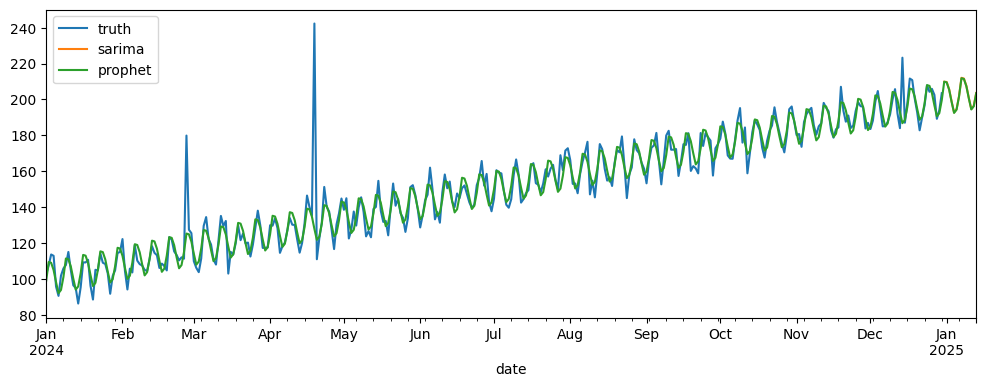

In [ ]:
# Day 11 - Cell 1: Load forecasts + truth, plot overlays
import pandas as pd, matplotlib.pyplot as plt
truth = features[features['region']==region].set_index('date')['demand']
sarima = pd.read_csv(f"/content/data/processed/sarima_{region}.csv", parse_dates=['date']).set_index('date')
prophet = pd.read_csv(f"/content/data/processed/prophet_{region}.csv", parse_dates=['ds']).rename(columns={'ds':'date','yhat':'prophet_yhat'}).set_index('date')
plt.figure(figsize=(12,4))
truth.plot(label='truth')
if not sarima.empty: sarima['sarima_forecast'].plot(label='sarima')
if not prophet.empty: prophet['prophet_yhat'].plot(label='prophet')
plt.legend(); plt.show()


In [ ]:
# Ensure truth_region exists and is a DataFrame with a demand column
truth_df = truth_region.copy()

# If it's a Series, convert it to DataFrame
if isinstance(truth_df, pd.Series):
    truth_df = truth_df.to_frame(name='demand')

truth_df.head()


,region,demand
date,,
2024-01-01,region_1,102.48
2024-01-02,region_1,107.40
2024-01-03,region_1,113.54
2024-01-04,region_1,112.78
2024-01-05,region_1,95.59


In [ ]:
alerts['date'] = pd.to_datetime(alerts['date'])


In [ ]:
alert_points = truth_df.loc[truth_df.index.intersection(alerts['date'])]
alert_points.head()


,region,demand
date,,
2024-04-19,region_1,242.29


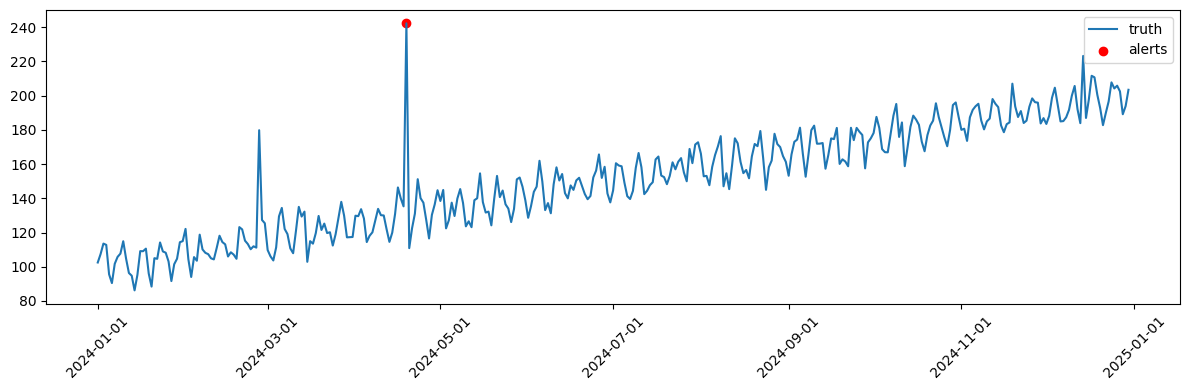

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,4))

# plot full demand curve
plt.plot(truth_df.index, truth_df['demand'], label='truth')

# convert alert dates to matplotlib format
alert_x = mdates.date2num(alert_points.index)
alert_y = alert_points['demand'].values

plt.scatter(alert_x, alert_y, color='red', label='alerts')

# pretty date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Day 11 - Cell 3: produce daily/weekly aggregates CSVs for Power BI
proc = pd.read_parquet("/content/data/processed/processed.parquet")
proc['week_start']=proc['date'].dt.to_period('W').apply(lambda r:r.start_time)
daily = proc.groupby(['region','date']).agg(demand=('demand','sum')).reset_index()
weekly = proc.groupby(['region','week_start']).agg(demand=('demand','sum')).reset_index()
daily.to_csv("/content/data/daily_region_demand.csv", index=False)
weekly.to_csv("/content/data/weekly_region_demand.csv", index=False)
print("Saved daily & weekly CSVs")


Saved daily & weekly CSVs


In [ ]:
# Day 12 - Cell 1: Mount Drive (optional)
from google.colab import drive
drive.mount('/content/drive')
# Copy artifacts to Drive folder 'DemandProject' (create it first)
!mkdir -p /content/drive/MyDrive/DemandProject
!cp /content/data/daily_region_demand.csv /content/drive/MyDrive/DemandProject/
!cp /content/data/weekly_region_demand.csv /content/drive/MyDrive/DemandProject/
print("Copied CSVs to Drive")


Mounted at /content/drive
Copied CSVs to Drive


In [ ]:
# Day 12 - Cell 2: Upload to S3 (optional; set AWS creds as env in Colab)
import boto3, os
if 'AWS_ACCESS_KEY_ID' in os.environ:
    s3 = boto3.client('s3')
    bucket = "your-bucket"
    s3.upload_file("/content/data/daily_region_demand.csv", bucket, "processed/daily_region_demand.csv")
    print("Uploaded to S3")
else:
    print("AWS creds not set; skipped S3 upload")


AWS creds not set; skipped S3 upload


In [ ]:
# Day 13 - Cell 1: Write FastAPI skeleton to file
app = r"""
from fastapi import FastAPI
import pandas as pd
app = FastAPI()
@app.get("/forecast/{region}")
def forecast(region: str):
    df = pd.read_csv("data/processed/sarima_{}.csv".format(region))
    return df.to_dict(orient="records")
@app.get("/alerts/{region}")
def alerts(region:str):
    df = pd.read_csv("data/alerts_consensus_{}.csv".format(region))
    return df.to_dict(orient="records")
"""
open("/content/app.py","w").write(app)
print("Wrote /content/app.py (FastAPI skeleton). Run locally with: uvicorn app:app --host 0.0.0.0 --port 8000")


Wrote /content/app.py (FastAPI skeleton). Run locally with: uvicorn app:app --host 0.0.0.0 --port 8000


In [ ]:
# Day 13 - Cell 2: Dockerfile skeleton (optional)
dockerfile = r"""
FROM python:3.10-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY . /app
CMD ["uvicorn","app:app","--host","0.0.0.0","--port","8000"]
"""
open("/content/Dockerfile","w").write(dockerfile)
print("Wrote Dockerfile")


Wrote Dockerfile


In [ ]:
# Day 14 - Cell 1: create simple GitHub Actions CI skeleton (write file)
ci = r"""
name: Build and test
on: [push]
jobs:
  test:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - name: Set up Python
        uses: actions/setup-python@v4
        with: python-version: '3.10'
      - name: Install
        run: pip install -r requirements.txt
      - name: Run tests
        run: pytest -q
"""
open(".github_workflow_ci.yml","w").write(ci)
print("Wrote CI skeleton (local preview).")


Wrote CI skeleton (local preview).


In [ ]:
# Day 14 - Cell 2: Scheduler notes (print)
print("""
Scheduling options:
- Colab: manual or use GitHub Actions to run notebooks on schedule (using nbconvert)
- GCP: Cloud Scheduler + Cloud Run (for containerized runner)
- AWS: EventBridge + ECS/Fargate or Lambda (depending on runtime)
""")



Scheduling options:
- Colab: manual or use GitHub Actions to run notebooks on schedule (using nbconvert)
- GCP: Cloud Scheduler + Cloud Run (for containerized runner)
- AWS: EventBridge + ECS/Fargate or Lambda (depending on runtime)



In [ ]:
# Day 15 - Cell 1: Write README
readme = """
# Demand Forecasting & Anomaly Detection - Colab version
Structure:
- Day01_ingest.ipynb ... Day15_docs.ipynb
Data:
- /content/data/raw
- /content/data/processed
Models:
- /content/data/models

Run order:
1. Day01_ingest.ipynb
2. Day02_preprocess.ipynb
...
"""
open("README.md","w").write(readme)
print("README saved")


README saved


In [ ]:
# Day 15 - Cell 2: Final checklist printout
print("""
Production checklist:
- Raw data immutable in storage
- Processed parquet partitioned
- Model artifacts versioned
- Retrain schedule + drift detection
- Monitoring + alerts + auth
""")



Production checklist:
- Raw data immutable in storage
- Processed parquet partitioned
- Model artifacts versioned
- Retrain schedule + drift detection
- Monitoring + alerts + auth



In [ ]:
import boto3
import os

session = boto3.Session(
    aws_access_key_id="YOUR_KEY",
    aws_secret_access_key="YOUR_SECRET",
    region_name="ap-south-1"
)

s3 = session.client("s3")

bucket = "demand-forecasting-ml-bucket"

# Upload models
paths = [
    f"{DATA_DIR}/models/{region}/lstm_model.keras",
    f"{DATA_DIR}/models/{region}/scaler.pkl"
]

for p in paths:
    key = os.path.basename(p)
    s3.upload_file(p, bucket, f"models/{region}/{key}")
    print("Uploaded:", key)


S3UploadFailedError: Failed to upload /content/data/models/region_1/lstm_model.keras to demand-forecasting-ml-bucket/models/region_1/lstm_model.keras: An error occurred (InvalidAccessKeyId) when calling the PutObject operation: The AWS Access Key Id you provided does not exist in our records.